# Windsat + TELSEM data
Explore the correlations between the training variables

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube
from src.model import xy_split
models_path = "../../models/"

# Select ascending (0) or descending (1) pass
swath = 0

In [29]:
#TELSEM ATLAS
telsem_folder = "../../data\processed\WinsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [30]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
swath_sd= model_preprocess(ds, swath_sector=swath)

# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_sd = swath_sd[d_vars]

swath_df = swath_sd.to_dataframe().dropna().reset_index("day_number")

# Map the day of the year (day_number) into the month:
day_mapping = []
days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

for i, n in enumerate(days_in_months):
    to_add = [i +1] * n
    day_mapping.extend(to_add)
len(day_mapping)


swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")
swath_df

surtep_ERA5     lat     lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                               
147           1014             275.894440 -53.125  73.625     194.885010   
161           995              276.849609 -49.625  68.875     211.529999   
              998              277.820099 -49.625  69.625     218.139999   
              999              278.050476 -49.625  69.875     217.937500   
              1000             277.954346 -49.625  70.125     213.382492   
...                                   ...     ...     ...            ...   
642           808              279.382294  70.625  22.125     198.187500   
              809              279.180969  70.625  22.375     204.407501   
              810              278.574554  70.625  22.625     208.712494   
              811              276.485809  70.625  22.875     210.847504   
657           796              275.716309  74.375  19.125     192.205002   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
147           1014               127.485001     215.657501     163.107498   
161           995                159.434998     230.509995     191.927490   
              998                172.832489     234.354996     200.334991   
              999                172.014999     234.285004     199.912506   
              1000               163.179993     231.119995     193.644989   
...                                     ...            ...            ...   
642           808                130.512497     208.532501     153.035004   
              809                142.735001     210.417496     160.252502   
              810                151.412506     212.059998     165.992493   
              811                155.565002     212.977493     169.082489   
657           796                121.514999     213.897491     159.597504   

                              month  
latitude_grid longitude_grid         
147           1014                1  
161           995                 1  
              998                 1  
              999                 1  
              1000                1  
...                             ...  
642           808                12  
              809                12  
              810                12  
              811                12  
657           796                12  

[1321151 rows x 8 columns]

In [31]:
# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,276.849609,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,0.734202,0.532538,0.790024,0.611630
2,277.820099,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,0.784180,0.620287,0.839752,0.712186
3,278.050476,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,0.766774,0.588146,0.826654,0.682101
4,277.954346,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,0.737401,0.536282,0.799926,0.626627
...,...,...,...,...,...,...,...,...,...,...,...
1321146,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1321147,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1321148,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1321149,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [32]:
X , y = xy_split(combined_df, y_column= "surtep_ERA5")
X

,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,-49.625,68.875,211.529999,159.434998,230.509995,191.927490,0.734202,0.532538,0.790024,0.611630
2,-49.625,69.625,218.139999,172.832489,234.354996,200.334991,0.784180,0.620287,0.839752,0.712186
3,-49.625,69.875,217.937500,172.014999,234.285004,199.912506,0.766774,0.588146,0.826654,0.682101
4,-49.625,70.125,213.382492,163.179993,231.119995,193.644989,0.737401,0.536282,0.799926,0.626627
...,...,...,...,...,...,...,...,...,...,...
1321146,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1321147,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1321148,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1321149,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [34]:
# Predict using some of our models:
# Save the original lat lon for plotting later
lat  = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

# Load a model
datestring = "local_windsatv2_A_2024_06_13T111608"
model_path = os.path.join(models_path, datestring + ".keras")
history_path = os.path.join(models_path, datestring + "_history")

model = load_model(model_path)
model.summary()

# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,595 (14.05 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 2,384 (9.32 KB)

41286/41286 ━━━━━━━━━━━━━━━━━━━━ 25s 603us/step


In [52]:
# Pearson´s correlaction coefficient.
from sklearn.feature_selection import r_regression

ccoeff = r_regression(X,y)
print("Pearson´s R coeffs")
for i, c in enumerate(ccoeff):
    print(f"{combined_df.columns[i + 1]} : {c:.5f}")

Pearson´s R coeffs
lat : -0.34955
lon : 0.06617
tbtoa_18Ghz_V : 0.71097
tbtoa_18Ghz_H : 0.39752
tbtoa_37Ghz_V : 0.74290
tbtoa_37Ghz_H : 0.45193
Emis19V : 0.14262
Emis19H : 0.03249
Emis37V : 0.09982
Emis37H : 0.01877


The ratio of theese coeafficienst and the ratio of the permutation importances with the trained models are very simmilar. but the emissivities' linear correlation is not as string as the model importance (non linear relationship ? )

In [36]:
# Compute Holme´s LST to compare
def holmes(tb: float):
    return 1.1*tb - 15.3

holmes_lst = combined_df["tbtoa_37Ghz_V"].apply(lambda x: holmes(x))


In [37]:
# Compare the error histogram of one of the models and Holme´s regression
holmes_error = combined_df["surtep_ERA5"] - holmes_lst

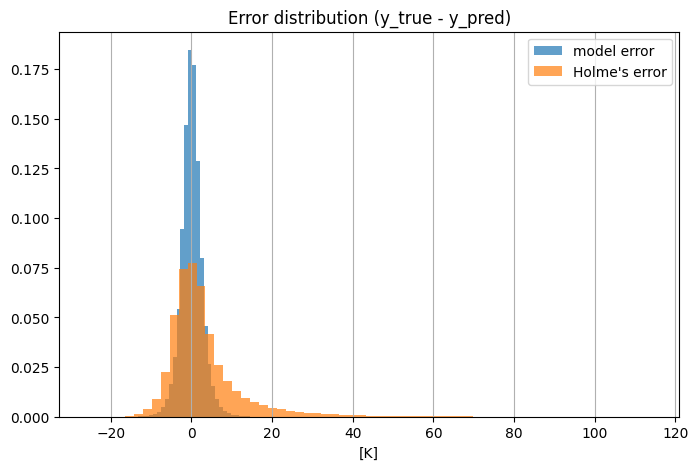

In [38]:
# Error histogram:
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60, label = "model error", alpha = 0.7
)
ax.hist(x = holmes_error,
    density = True, bins = 60, label = "Holme's error", alpha = 0.7
)
ax.grid(axis="x")

ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
ax.legend()
plt.show()

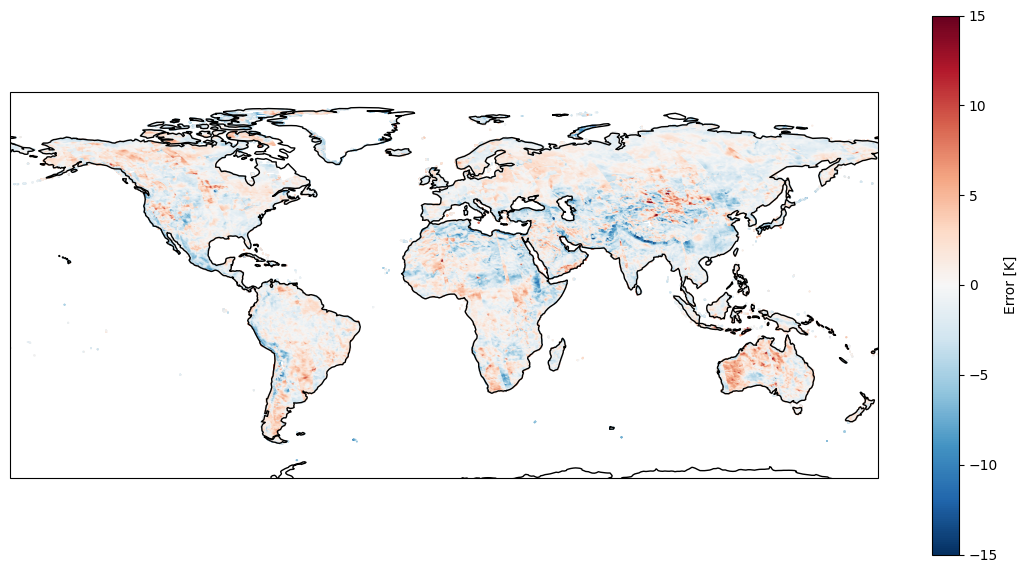

In [41]:
# Error map projections:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=15, clip = False)

scatter = ax.scatter(
    x = lon,
    y = lat,
    s= 0.1,
    alpha = 1,
    c = combined_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()

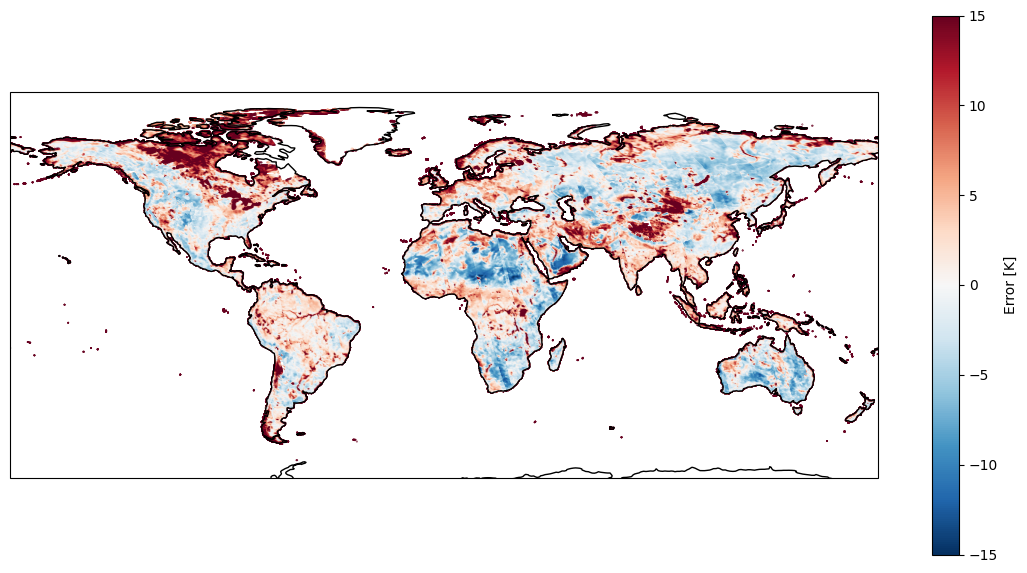

In [42]:
# Error map projections:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=15, clip = False)

scatter = ax.scatter(
    x = lon,
    y = lat,
    s= 0.1,
    alpha = 1,
    c = holmes_error,
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label='Error [K]')
plt.show()

To be fair, we should probably remove water bodies to do this comparison ... 